In [1]:
import numpy as np
import cv2
import time
import datetime
import os
import shutil
import dill
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.models import Sequential, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.neighbors.kde import KernelDensity
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

Using TensorFlow backend.


In [2]:
class VideoStream:
    
    def __init__(self, filepath):
        self.cap = cv2.VideoCapture(filepath)
        if not self.cap.isOpened():
            raise Exception('Video stream doesn\'t open!')
    
    def __enter__(self):
        return self.cap
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.cap.release()

In [91]:
class ShortVideoException(Exception):
    
    def __init__(self, message):
        super().__init__()
        self.message = message
        
    def __str__(self):
        return self.message

In [171]:
class ImageSequenceGenerator():
    
    def __init__(
        self,
        directory,
#         target_size=(256, 256),
#         class_mode='categorical',
#         batch_size=32
        timesteps_cnt=10,
        fps=None,
        skip_short_video=False
    ):
        self.directory = directory
        self.timesteps_cnt = timesteps_cnt
        self.skip_short_video = skip_short_video
        self.video_paths = self._set_video_paths()
        
    def _set_video_paths(self):
        video_paths = []
        classes = os.listdir(self.directory)
        for c in classes:
            class_path = os.path.join(self.directory, c)
            video_names = os.listdir(class_path)
            paths = list(map(lambda x: os.path.join(class_path, x), video_names))
            video_paths.extend(paths)
        print('Found {} videos belonging to {} classes'.format(len(video_paths), len(classes)))
    
    
#     def _check_video_length(self, video_path):
#         with VideoStream(video_path) as cap:
#             frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#             if frames_cnt < self.timesteps_cnt:
#                 is_short = 1
#             else:
#                 is_short = 0
#         return is_short, frames_cnt
    
#     def get_video_paths(self):
#         gen = os.walk(self.directory)
#         video_paths = []
#         for l in gen:
#             if len(l[1]) != 0:
#                 classes = l[1]
#             if len(l[2]) != 0:
#                 paths = list(map(lambda x: os.path.join(l[0], x), l[2]))
#                 video_paths.extend(paths)
#         return video_paths
    
#     def _select_videos_by_length(self):
#         video_paths = self._get_video_paths()
#         selected_videos = []
#         short_videos = []
#         for video_path in video_paths:
#             is_short, frames_cnt = self._check_video_length(video_path)
#             if is_short:
#                 short_videos.append((video_path, frames_cnt))
#             else:
#                 selected_videos.append(video_path)
#         message_short_videos = ['Video: {}; Frames: {}'.format(i[0], i[1]) for i in short_videos]
#         message_short_videos = '\n'.join(message_short_videos)
#         if not self.skip_short_video and len(short_videos) != 0:
#             exception_message  = 'There are a videos that too short '
#             exception_message += 'for choosen timesteps. \n'
#             exception_message += 'Timesteps: {}\n{}'
#             raise ShortVideoException(exception_message.format(self.timesteps_cnt, message_short_videos))
#         else:
#             print('Skipped videos\n{}'.format(message_short_videos))
#         return selected_videos
    
#     def get_random_video(self, seed=None):
#         video_paths = self._select_videos_by_length()
#         if seed is not None:
#             np.random.seed(seed)
#         random_video = np.random.choice(video_paths)
#         return random_video
            

In [172]:
tmp = ImageSequenceGenerator('../videos/cut/train/', 6000, skip_short_video=True)

Found 11 videos belonging to 2 classes


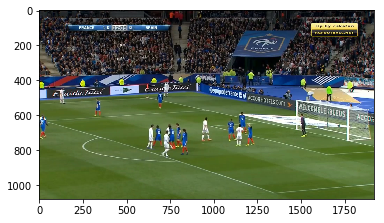

In [63]:
def get_random_sequence(filepath, timesteps_cnt):
    frame_sequence = []
    with VideoStream(filepath) as cap:
        frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start = np.random.randint(0, frames_cnt - timesteps_cnt)
        end = start + timesteps_cnt
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        for i in range(start, end):
            ret, frame = cap.read()
            if ret == True:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_sequence.append(frame)
            else:
                break
    frame_sequence = np.array(frame_sequence)
    return frame_sequence
    
tmp = get_random_sequence('../videos/input/train/0/video.mp4', 10)

In [66]:
np.random.randint(0, 1)

0

'../videos/cut/train/0\\France_Spain_1_32_00_1_38_00.mp4'

In [59]:
timesteps_cnt = 10

frame_sequence = []
with VideoStream('../videos/input/train/0/video.mp4') as cap:
    frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    start = np.random.randint(0, frames_cnt - timesteps_cnt)
    end = start + timesteps_cnt
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)
    for i in range(start, end):
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_sequence.append(frame)
        else:
            break
frame_sequence = np.array(frame_sequence)

In [62]:
frame_sequence.shape

(10, 1080, 1920, 3)

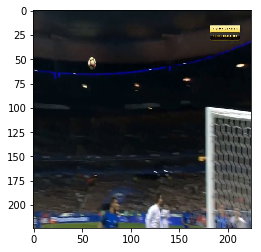

In [64]:
img = cv2.resize(frame, (224, 224))
plt.imshow(img)

In [ ]:
class ImageSequenceGenerator(Sequence):
    
    def __init__(
        self,
        directory,
        target_size=(256, 256),
        class_mode='categorical',
        batch_size=32
    ):
        

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

In [31]:
v = VideoStream('../videos/input/train/0/video.mp4')

In [32]:
cap = v.__enter__()

In [33]:
cap.isOpened()

False

In [10]:
cap = cv2.VideoCapture('../videos/input/train/0/video.mp4')

In [13]:
if not cap.isOpened():
    raise Exception('Video stream doesn\'t open!')

In [14]:
cap.release()

In [9]:
os.listdir('../videos/input/train/0')

['video.mp4']